# fetch data, install packages, load packages

In [ ]:
# !git clone https://github.com/Jbollenbacher/data-scientist-exercise02.git
# !pip install pandas sklearn umap-learn sentence-transformers matplotlib hdbscan

In [ ]:
import json
import pandas as pd
import numpy as np
import os
from collections import Counter

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer #common bag of words models
from sentence_transformers import SentenceTransformer # a deep-learning-based model

# Load data

In [ ]:
#load aviation data table

av = pd.read_csv('./data-scientist-exercise02/data/AviationData.csv')

for col in av.columns:  #convert all date columns to datetimes
    if 'Date' in col: av[col] = pd.to_datetime(av[col])  

In [ ]:
# load narratives data

files = os.listdir('./data-scientist-exercise02/data/') #get all files in data directory
files = [f for f in files if 'NarrativeData' in f] #keep only narrative jsons

narratives = list()
for f in files: 
    narratives += json.load(open('./data-scientist-exercise02/data/'+f, 'rb'))['data'] #load each file, add all events to narratives list
    
narratives = pd.DataFrame(narratives) #convert list of dicts to pandas df
narratives.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76133 entries, 0 to 76132
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   EventId         76133 non-null  object
 1   narrative       76133 non-null  object
 2   probable_cause  76133 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [ ]:
#merge/join tables
df = av.merge(right = narratives, on = 'EventId', how='inner') #add narratives to av data
df = df[df['narrative']!=''] #drop null entries 

# initial text cleaning and inspection

In [ ]:
#seperate first sentence from narrative.  it concerns only evidence sources, not probable causes
df['evidence_statement'] = df['narrative'].apply(lambda x: x.split('.', 1)[0])
df['narrative'] = df['narrative'].apply(lambda x: '.'.join(x.split('.')[1:]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#manually inspect a sample text. repeat as needed
df['narrative'].sample(1).reset_index(drop=True).iloc[0]

"TWO AIRPLANES WERE CONVERGING HEAD-ON WHILE TAXIING ON THE SAME EAST-WEST TAXIWAY. THE PILOT OF THE CESSNA 182 WAS TAXIING EAST AND SAW THE TAILWHEEL EQUIPPED GREAT LAKES 2T-1AK (BIPLANE) 'S-TURNING' ON THE TAXIWAY. SHE ASSUMED THE BIPLANE PILOT SAW HER AIRCRAFT. AS THE TWO AIRPLANES GOT CLOSER, THE CESSNA PILOT SLOWED AND MOVED TO THE RIGHT SIDE OF THE TAXIWAY, SO THE AIRPLANES COULD PASS WING TIP TO WING TIP. THE WESTBOUND BIPLANE THEN 'S-TURNED' LEFT TOWARDS THE CESSNA. THE CESSNA PILOT IMMEDIATELY VEERED RIGHT AND TAXIED OFF THE PAVEMENT INTO THE DIRT, BUT THE AIRPLANES COLLIDED. AFTER THE COLLISION, THE WESTBOUND BIPLANE PILOT STATED TO AIRPORT OFFICIALS THAT HE NEVER SAW THE CESSNA. THE SUN WAS SETTING AT THE TIME OF THE COLLISION. "

In [ ]:
#standardize common abbreviations, acronyms, names

aliases = { # manually created a list of common abbreviations by inspecting the data 
        'federal aviation administration': 'faa', 
        'flt': 'flight',
        'hrs':'hours',
        'plt':'pilot',
        '&':'and',
        'acft':'aircraft',
        ' rnw':' runway',
        'feet':'ft',
        'ldg':'landing',
        'lndg': 'landing',
        'dept':'department',
        ' agl': ' above ground level',
        ' abt':' about',
        'aprx': 'approximately',
        'Approx': 'approximately',
         }

def replace_aliases_in_text(text, aliases):
    for k in aliases.keys():
        text = text.replace(k, aliases[k])
    return text

df['narrative'] = df['narrative'].apply(lambda x: replace_aliases_in_text(x.lower(), aliases))

In [ ]:
df.info()
df.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77026 entries, 1 to 77256
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   EventId               77026 non-null  object        
 1   InvestigationType     77026 non-null  object        
 2   AccidentNumber        77026 non-null  object        
 3   EventDate             77023 non-null  datetime64[ns]
 4   Location              76945 non-null  object        
 5   Country               76517 non-null  object        
 6   Latitude              23722 non-null  float64       
 7   Longitude             23713 non-null  float64       
 8   AirportCode           43300 non-null  object        
 9   AirportName           46027 non-null  object        
 10  InjurySeverity        77021 non-null  object        
 11  AircraftDamage        74747 non-null  object        
 12  AircraftCategory      16496 non-null  object        
 13  RegistrationNumb

,EventId,InvestigationType,AccidentNumber,EventDate,Location,Country,Latitude,Longitude,AirportCode,AirportName,InjurySeverity,AircraftDamage,AircraftCategory,RegistrationNumber,Make,Model,AmateurBuilt,NumberOfEngines,EngineType,FARDescription,Schedule,PurposeOfFlight,AirCarrier,TotalFatalInjuries,TotalSeriousInjuries,TotalMinorInjuries,TotalUninjured,WeatherCondition,BroadPhaseOfFlight,ReportStatus,PublicationDate,narrative,probable_cause,evidence_statement
1,20150901X92332,Accident,CEN15LA392,2015-08-31,"Houston, TX",United States,29.809444,-95.668889,IWS,WEST HOUSTON,Non-Fatal,Substantial,Airplane,N452CS,CESSNA,T240,No,NaN,NaN,Part 91: General Aviation,NaN,Instructional,NaN,NaN,NaN,NaN,2.0,VMC,LANDING,Preliminary,2015-09-04,the flight instructor and private pilot under...,,"On August 31, 2015, about 1230 central dayligh..."
5,20150831X30510,Accident,WPR15LA253B,2015-08-28,"Las Vegas, NV",United States,36.099444,-115.162500,LAS,McCarran International,Non-Fatal,Minor,Airplane,N187AA,DASSAULT,FALCON2000,No,2.0,Turbo Jet,Part 91: General Aviation,NaN,Business,NaN,NaN,NaN,NaN,5.0,VMC,STANDING,Preliminary,2015-09-03,"the c90 sustained substantial damage, and the...",,"On August 28, 2015, about 1010 Pacific dayligh..."


# explore some summary stats

In [ ]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [ ]:
#define a helper function
def get_word_freq_dict(text):
    wordlist = text.split()
    wordfreq = Counter(wordlist)
    return wordfreq

In [45]:
# Check wordcounts of texts

narrative_wordcounts = df['narrative'].apply(lambda x: len(x.split(' ')))
print('mean',narrative_wordcounts.mean())
print('median',narrative_wordcounts.median())
print('fraction <500', (narrative_wordcounts < 500).sum()/len(narrative_wordcounts))
print('fraction <200', (narrative_wordcounts < 200).sum()/len(narrative_wordcounts))

mean 125.02924669574843
median 104.0
fraction <500 0.9923823165570675
fraction <200 0.8704342730646526


**Conclusion**: texts are almost all short 

This suggests transformer-based embeddings may be appropriate.

In [ ]:
#explore most common words

all_texts = '\n'.join(list(df['narrative'])) #combine all narratives to single string
word_freqs = get_word_freq_dict(all_texts) # get word counts
word_freqs = {k:word_freqs[k] for k in word_freqs.keys() if k not in ENGLISH_STOP_WORDS} #remove stopwords
word_freqs = pd.DataFrame(list(zip(word_freqs.keys(),word_freqs.values())), columns = ['word','count']) #to dataframe
word_freqs = word_freqs.sort_values(by='count', ascending=False).reset_index(drop=True) #show most common words
word_freqs.info()
word_freqs.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141970 entries, 0 to 141969
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   word    141970 non-null  object
 1   count   141970 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.2+ MB


,word,count
0,pilot,145235
1,airplane,104788
2,aircraft,61914
3,engine,55174
4,landing,52916
5,flight,50984
6,fuel,42399
7,left,41691
8,reported,39592
9,right,35235


**Conclusion**: vocab is very large

This suggests many unique words, e.g. proper nouns, typos, nonstandard abreviations. Adds to noise in any analysis.

**Conclusion**:  top ~100 words dont look super informative.

This suggest low dimensional bag of words embeddings may fail

# produce text embeddings 

create BERT, TFIDF, and word-count embeddings for each narrative

In [ ]:
import torch #supports SentenceTransformer usage
torch.cuda.is_available()

In [ ]:
#make BERT embeddings. warning, very slow. 10min on GPU, much longer on CPU
bert_model = SentenceTransformer('stsb-distilbert-base')
bert_embs = bert_model.encode(list(df['narrative']), 
                                   show_progress_bar=True, 
                                   device = torch.device('cuda'))#delete this param if cuda unavailable
df['bert_emb'] = list(bert_embs)

In [ ]:
#make rawcount embeddings. 
rawcount_model = CountVectorizer(ngram_range=(1,1), stop_words = 'english', max_features=750) 
rawcount_embs = rawcount_model.fit_transform(list(df['narrative']))
df['rawcount_emb'] = pd.Series(list(rawcount_embs)).apply(lambda x: x.toarray().flatten())

In [ ]:
#make tfidf embeddings
tfidf_model = TfidfVectorizer(ngram_range=(1,1), stop_words = 'english', max_features=750) 
tfidf_embs = tfidf_model.fit_transform(list(df['narrative']))
df['tfidf_emb'] = pd.Series(list(tfidf_embs)).apply(lambda x: x.toarray().flatten())

In [ ]:
df.to_parquet('./drive/MyDrive/df_with_embs.parquet')

# project and cluster text embeddings

###initial projection and inspection of different embeddings

project down to 2d using umap to visualize

In [ ]:
import umap
import matplotlib.pyplot as plt
import hdbscan

In [ ]:
df = pd.read_parquet('./drive/MyDrive/df_with_embs.parquet')
df = df[~df['tfidf_emb'].isna()] #drops empty-string and whitespace narratives

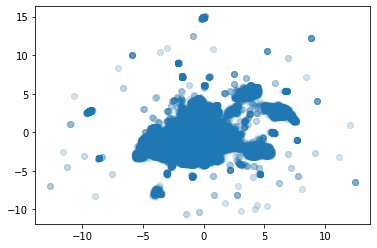

In [20]:
# project and visualize bert embeddings
umap_model = umap.UMAP(n_neighbors=7, n_components=2)
bert_emb_umap_proj = umap_model.fit_transform(np.array(list(df['bert_emb'])))
plt.scatter(bert_emb_umap_proj[:,0], bert_emb_umap_proj[:,1], alpha=0.05)

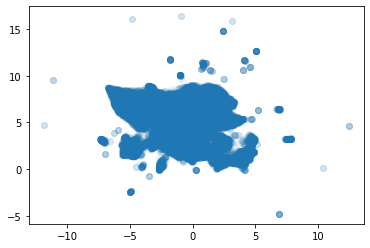

In [ ]:
# project and visualize wordcount embeddings
umap_model = umap.UMAP(n_neighbors=7, n_components=2)
rawcount_emb_umap_proj = umap_model.fit_transform(np.array(list(df['rawcount_emb'].dropna())))
plt.scatter(rawcount_emb_umap_proj[:,0], rawcount_emb_umap_proj[:,1], alpha=0.05)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


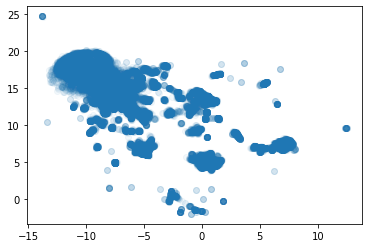

In [ ]:
# project and visualize tfidf embeddings
umap_model = umap.UMAP(n_neighbors=9, n_components=2)
tfidf_emb_umap_proj = umap_model.fit_transform(np.array(list(df['tfidf_emb'].dropna())))
plt.scatter(tfidf_emb_umap_proj[:,0], tfidf_emb_umap_proj[:,1], alpha=0.05)

**Conclusion**: tfidf embeddings look most seperated in 2d.

Use tfidf for clustering first. also try BERT

**Conclusion**: Cluster seperation is not superb in 2dembeddings.

Perhaps try higher dimensional embedding for clustering if 2d is unsuccessful

### cluster attempt 1

Use HDBSCAN to cluster the UMAP-projected embedddings.  
Start with 2d, try higher dimensional projections if cluster seperation is poor. 

 5    38118
 4    12819
-1     8284
 0     5964
 2     4362
 1     4051
 3     3197
Name: label, dtype: int64


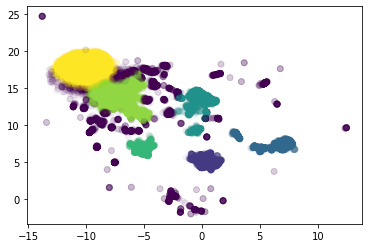

In [ ]:
#cluster from initial 2d tfidf embeddings
clusterer = hdbscan.HDBSCAN(min_cluster_size=1000)
clusterer.fit(tfidf_emb_umap_proj)
df['label'] = clusterer.labels_

#inspect cluster distribution
print(df['label'].value_counts())

#visualize clusters in 2d
plt.scatter(tfidf_emb_umap_proj[:,0], tfidf_emb_umap_proj[:,1], c = list(df['label']), alpha=0.05)

In [ ]:
#inspect categories
cluster_to_inspect = 0
pd.options.display.max_colwidth = 1000
df[['narrative','label']][df['label']==cluster_to_inspect].sample(5)

,narrative,label
14439,"while taxing for departure, the airplane's no. 12 tire on the right body landing gear contacted foreign object debris (fod), which resulted in a cut tire and loss of pressure. an electronic message reflecting the loss of pressure in the no. 12 tire was displayed on the engine indicating and crew alerting system (eicas) in the cockpit; however, no further action was taken by the flight crew. during the takeoff roll, the two aft tires, no. 11 (inboard) and 12 (outboard), on the right body landing gear (rblg) burst and their associated wheels fractured, which caused minor damage to the airplane. the airplane returned back to the airport and landed uneventfully. examination of the airplane's systems and wheel assemblies revealed no additional anomalies.",5
18194,"when the airplane turned downwind, the engine lost power. the pilot attempted to restart the engine, and it surged suddenly. the torque caused the airplane to roll inverted. the pilot managed to roll the airplane upright, but was unable to restart the engine and he made a forced landing on airport property, striking the ground hard and substantially damaging the airplane. examination and tesing of the carburetor revealed the enrichment cover was leaking, and there was ""a substantial leak"" at one of the vapor vent ports. one of the vapor vent floats was not functioning. when the vapor vent port was plugged, the carburetor tested between 7 and 22 pounds per hour above the rich limit.",5
28510,"the pilot reported that she leaned the mixture prior to takeoff. shortly after departure, during the climb, the pilot readjusted the mixture (aft) due to poor aircraft performance. shortly after readjusting the mixture, the engine began to run rough and eventually quit. the pilot initiated a forced landing to an open field near the airport. during the landing roll, the aircraft's nose gear collapsed. substantial damage was reported to the aircraft's left wing, left aileron and firewall. the density altitude at nampa airport, during the same timeframe as the accident, was approximately 3,890 ft.",5
9979,"the pilot reported that at 70 miles from his destination he determined that he would be landing closer to minimum fuel than he had planned. he continued to the destination and passed over one airport because it did not have any services. at 35 miles from the destination, the low fuel caution-warning for fuel tank 2 illuminated, followed by a low fuel caution-warning for fuel tank 1. the pilot thought that he would still land with some reserve and continued to fly to his destination airport. approximately 1 mile from the destination airport the helicopter experienced a dual engine flame-out. the pilot autorotated to a sports field where the helicopter landed hard, sustaining damage to the main rotor blades, tail rotor, tail boom, and horizontal stabilizer. the pilot stated that the helicopter and engines had no mechanical failures or malfunctions during the flight.",5
72096,"according to the surviving passenger, a boy, the pilot was flying the aircraft from the right seat. the aircraft was flown to the vicinity of the pilot's property where he made a pass over a farm belonging to a relative. the low pass was made near the operator of a combine who was harvesting grain in a field. during the pass, the aircraft collided with a power line, crashed and burned. the boy was the only occupant to escape from the plane.",5


**Conlusion**: tfidf yeilds clear geometric seperation, but clusters dont seem useful in terms of text content. 

Try BERT, may yeild better results than tfidf. 

### Cluster attempt 2

Try BERT embeddings. 

 7    57574
 8     5394
 5     5284
 3     2862
-1     2095
 4     1177
 2     1089
 0      595
 1      394
 6      331
Name: label, dtype: int64


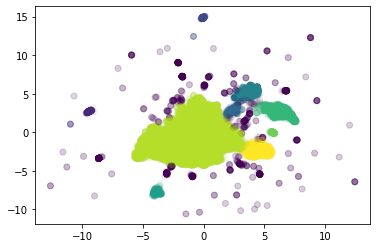

In [22]:
#cluster from initial 2d bert embeddings
clusterer = hdbscan.HDBSCAN(min_cluster_size=250)
clusterer.fit(bert_emb_umap_proj)
df['label'] = clusterer.labels_

#inspect cluster distribution
print(df['label'].value_counts())

#visualize clusters in 2d
plt.scatter(bert_emb_umap_proj[:,0], bert_emb_umap_proj[:,1], c = list(df['label']), alpha=0.05)

In [ ]:
#inspect categories
cluster_to_inspect = 8
pd.options.display.max_colwidth = 1000
df[['narrative','label']][df['label']==cluster_to_inspect].sample(5)

cluster descriptions from clustering attempt two:

0. hot air balloon accidents 
1. empty string narratives (should have filtered out. oops.)
2. reports featuring descriptions of injuries and aircraft ownership. probably insurance reports.
3. reports with many proper nouns, especially location names
4. glider accidents
5. helicopter accidents
6. extreme weather incidents
7. pilot error
8. student pilot accidents

Conclusion: (BERT + UMAP + HDBSCAN) has clustered the text into meaninful categories. However, the categories do not deal primarily with probable causes of the accidents, except for categories 6,7,8.

# Final visualization

In [138]:
from matplotlib.lines import Line2D

In [163]:
cluster_names = {
                 0:'hot air balloon accidents',
                 1: 'no narrative given', 
                 2: 'insurance reports',
                 3: 'accidents in foreign airspace',
                 4: 'glider accidents',
                 5: 'helicopter accidents',
                 6: 'extreme weather incidents',
                 7: 'pilot error',
                 8: 'student pilot accidents',
                 -1:'unclustered'
}

In [164]:
# reformat plotting data for conveneience
x = bert_emb_umap_proj[:,0]
y = bert_emb_umap_proj[:,1]
labels = list(df['label'])
names = [cluster_names[c] for c in labels]

plot_data = pd.DataFrame(zip(x, y, labels, names), columns = ['x','y','label', 'name'])
# plot_data = plot_data[plot_data['label']!=1] #drop empty string cluster.

In [165]:
#reorder cluster labels by cluster size, and put unclustered data last
cluster_rename_map = dict(zip(list(plot_data[plot_data['label']!=-1]['label'].value_counts().index), range(0,100)))
cluster_rename_map[-1] = len(cluster_rename_map)
plot_data['label'] = plot_data['label'].apply(lambda x: cluster_rename_map[x] if x in cluster_rename_map else x)
plot_data['label'].value_counts()

0    57574
1     5394
2     5284
3     2862
9     2095
4     1177
5     1089
6      595
7      394
8      331
Name: label, dtype: int64

In [166]:
plot_data = plot_data.sort_values('label')

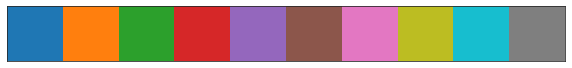

In [167]:
#set font size of labels on matplotlib plots
plt.rc('font', size=16)

#set style of plots
sns.set_style('white')

#define a color palette. a reodered tab10 palette. put grey last for null cluster
customPalette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#bcbd22','#17becf','#7f7f7f']
sns.set_palette(customPalette)
sns.palplot(customPalette)

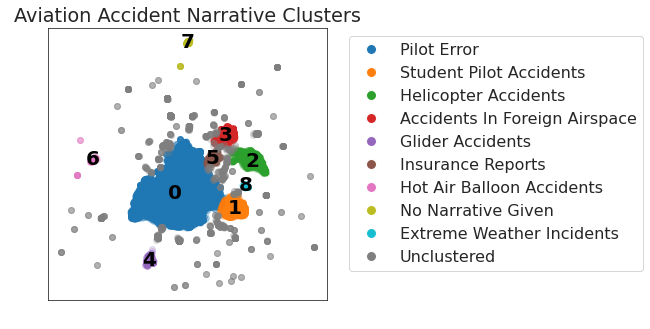

In [169]:
#create a new figure
plt.figure(figsize=(5,5))

#loop through labels and plot each cluster
legend_elements = list()
for i, label in enumerate(plot_data['label'].unique()):

    #add data points 
    plt.scatter(x=plot_data.loc[plot_data['label']==label,'x'], 
                y=plot_data.loc[plot_data['label']==label,'y'], 
                color=customPalette[i], 
                alpha=0.20)
    
    #add label
    if label != len(plot_data['label'].unique())-1: #for all clusters, plot
      plt.annotate(label, 
                  plot_data.loc[plot_data['label']==label,['x','y']].mean(),
                  horizontalalignment='center',
                  verticalalignment='center',
                  size=20, weight='bold',
                  color='k') 
      
    #make legend element
    cluster_name = list(plot_data.loc[plot_data['label']==label,'name'])[0] #get name
    cluster_name = cluster_name.title() #make name title case
    legend_elements.append(Line2D([0], [0], marker='o', 
                                  color='w', label=cluster_name,
                                  markerfacecolor=customPalette[i], 
                                  markersize=10))
      
#hide tick labels
plt.xticks(color='w')
plt.yticks(color='w')

#create legend
plt.legend(handles = legend_elements, bbox_to_anchor=(1.05, 1.0))
plt.title('Aviation Accident Narrative Clusters')

plt.show()